<a href="https://colab.research.google.com/github/marc-queiroz/ml_lab3/blob/master/simple_cnn_using_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Simple CNN using Keras](https://www.kaggle.com/frlemarchand/simple-cnn-using-keras/data)

### The goal of this kernel is to create a simple Convolution Neural Network that will allow to differentiate images that contains cacti from images that do not. While better results closer to 100% accuracy could be designed using layers from pre-trained models such as VGG16, we want to stick with a fairly simple CNN architecture and see how far we can go, and whether pre-trained layers are even needed.

## REALIZANDO OS IMPORTS

Aqui reliza-se as importações dos pacotes que serão utilizados nos experimentos.

In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
from shutil import copyfile, move
from tqdm import tqdm
import h5py
import numpy as np
from numpy import expand_dims
import cv2
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import f1_score as sklearn_f1_score
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix

from PIL import Image

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, BatchNormalization
from keras.models import Model
from keras.regularizers import l2

from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

import os
import time
from datetime import datetime
import glob
from tempfile import mkstemp
from shutil import move, copymode
from os import fdopen, remove

Just a quick check to make verify Tensorflow version and whether the GPU is found.

In [ ]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.3.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## IMPORTANDO OS DADOS DO GITHUB

In [ ]:
!rm -rf ml_lab3/
!git clone https://github.com/marc-queiroz/ml_lab3 ml_lab3

Cloning into 'ml_lab3'...
remote: Enumerating objects: 20017, done.
remote: Counting objects: 100% (20017/20017), done.
remote: Compressing objects: 100% (20014/20014), done.
remote: Total 44273 (delta 6), reused 20010 (delta 3), pack-reused 24256
Receiving objects: 100% (44273/44273), 134.44 MiB | 35.14 MiB/s, done.
Resolving deltas: 100% (20/20), done.
Checking out files: 100% (55128/55128), done.


## DEFININDO AS FUNÇÕES AUXILIARES

In [ ]:
def resize_data(data, size, convert):
	if convert:
		data_upscaled = np.zeros((data.shape[0], size[0], size[1], 3))
	else:
		data_upscaled = np.zeros((data.shape[0], size[0], size[1]))
	for i, img in enumerate(data):
		large_img = cv2.resize(img, dsize=(size[1], size[0]), interpolation=cv2.INTER_CUBIC)
		data_upscaled[i] = large_img
	return data_upscaled

def load_images(image_paths, convert=False):
	x = []
	y = []
	for image_path in image_paths:		
		path, label = image_path.split(' ')	  
		path= './ml_lab3/' + path
		if convert:
			image_pil = Image.open(path).convert('RGB') 
		else:
			image_pil = Image.open(path).convert('L')
		img = np.array(image_pil, dtype=np.uint8)
		x.append(img)
		y.append([int(label)])
	x = np.array(x)
	y = np.array(y)
	if np.min(y) != 0: 
		y = y-1
	return x, y

def load_dataset(train_file, test_file, resize, convert=False, size=(224,224)):
	arq = open(train_file, 'r')
	texto = arq.read()
	train_paths = texto.split('\n')
	print ('Size:', size)
	train_paths.remove('')
	train_paths.sort()
	print ("Loading training set...")
	x_train, y_train = load_images(train_paths, convert)
	arq = open(test_file, 'r')
	texto = arq.read()
	test_paths = texto.split('\n')
	test_paths.remove('')
	test_paths.sort()
	print ("Loading testing set...")
	x_test, y_test = load_images(test_paths, convert)
	if resize:
		print ("Resizing images...")
		x_train = resize_data(x_train, size, convert)
		x_test = resize_data(x_test, size, convert)
	if not convert:
		x_train = x_train.reshape(x_train.shape[0], size[0], size[1], 1)
		x_test = x_test.reshape(x_test.shape[0], size[0], size[1], 1)
	print (np.shape(x_train))
	return (x_train, y_train), (x_test, y_test)
 
def generate_labels(x_test, y_test):
  labels = []
  for i in range(len(x_test)):
    labels.append(y_test[i][0])
  return labels

def normalize_images(x):
  x = x.astype('float32')
  x /= 255
  return x

def convert_vector(x, num_classes):
  return keras.utils.to_categorical(x, num_classes)

def fit_model(model, x_train, y_train, x_test, y_test, epochs, batch_size=128, verbose=1, steps_per_epoch=None):
  return model.fit(x=x_train, y=y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), verbose=verbose, steps_per_epoch=steps_per_epoch)

def get_confusion_matrix(model, x_test, labels):
  pred = []
  y_pred = model.predict_classes(x_test)
  for i in range(len(x_test)):
    pred.append(y_pred[i])
  return confusion_matrix(labels, pred)

def plot_graphs(history, filename=None):
	acc = history.history['accuracy']
	val_acc = history.history['val_accuracy']
	loss = history.history['loss']
	val_loss = history.history['val_loss']
	epochs = range(len(acc))
	fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
	ax1.plot(epochs, acc, 'b', label='Acurácia do treinamento')
	ax1.plot(epochs, val_acc, 'r', label='Acurácia da validação')
	ax1.set_title('Acurácia do treinamento e validação')
	ax1.legend()
	ax2.plot(epochs, loss, 'b', label='Perda do treinamento')
	ax2.plot(epochs, val_loss, 'r', label='Perda da validação')
	ax2.set_title('Perda do treinamento e validação')
	ax2.legend()
	if (filename):
		fig.savefig(filename)
		from google.colab import files
		files.download(filename)
	plt.show()

def extract_features(input_file, output_file, img_rows, img_cols, dir_dataset):
	file_input = open (input_file, 'r')
	input = file_input.readlines()
	file_input.close()
	output = open(output_file, 'w')
	model = InceptionV3(weights='imagenet', include_top=False)
	for i in input:
		sample_name, sample_class = i.split()
		img_path = dir_dataset + sample_name
		print(img_path)
		img = image.load_img(img_path, target_size=(img_rows,img_cols))
		img_data = image.img_to_array(img)
		img_data = np.expand_dims(img_data, axis=0)
		img_data = preprocess_input(img_data)
		inception_features = model.predict(img_data)
		features_np = np.array(inception_features)
		features_np = features_np.flatten()
		output.write(sample_class+' ')
		for j in range (features_np.size):
			output.write(str(j+1)+':'+str(features_np[j])+' ')
		output.write('\n')
	print(features_np.size)
	output.close()
 
def round_float(value):
	return float("{:.3f}".format(value))
 
def get_time():
    return time.time()

def get_time_diff(start_time):
    end_time = time.time()
    return round_float(end_time - start_time)

def plot_confusion_matrix(cm, filename=None):
	fig = plt.figure(figsize=(10,10))
	ax = fig.add_subplot(111)
	cax = ax.matshow(cm)
	for (x, y), value in np.ndenumerate(cm):
		plt.text(x, y, f"{value:.0f}", va="center", ha="center")
	plt.title('Matriz de Confusão')
	fig.colorbar(cax)
	plt.xlabel('Predicted')
	plt.ylabel('True')
	if (filename):
		fig.savefig(filename)
		from google.colab import files
		files.download(filename)
	plt.show()

print('DEFININDO AS FUNÇÕES DE PREPARAÇÃO DE DADOS - DONE', datetime.now())


DEFININDO AS FUNÇÕES DE PREPARAÇÃO DE DADOS - DONE 2020-09-06 16:18:33.071990


# Prepare the data

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, Reshape, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Load data

In [ ]:
TRAIN_FILE = "./ml_lab3/train.txt"
TEST_FILE = "./ml_lab3/test.txt"

# Model Creation: Convolutional Neural Network

Some really insightful comments about deep learning model optimization can be found here (https://karpathy.github.io/2019/04/25/recipe/ ). 

In [ ]:
def cnn_model(img_rows, img_cols, num_classes):
  dropout_dense_layer = 0.6

  model = Sequential()
  model.add(Conv2D(32, (3, 3), input_shape=(img_rows, img_cols, 3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3, 3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Flatten())
  model.add(Dense(1024))
  model.add(Activation('relu'))
  model.add(Dropout(dropout_dense_layer))

  model.add(Dense(256))
  model.add(Activation('relu'))
  model.add(Dropout(dropout_dense_layer))

  model.add(Dense(num_classes))
  model.add(Activation('sigmoid'))
  return model

# Treino e validação


Size: (48, 48)
Loading training set...
Loading testing set...
Resizing images...
(1578, 48, 48, 3)
Loss: 0.7717452049255371
Accuracy: 0.8728179335594177
Execution Time: 38.632
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Confusion Matrix: 
 [[34  1  1  0  2  1  0  0  0  0  0  0]
 [ 3 25  2  0  0  0  0  1  0  0  1  0]
 [ 0  0 34  0  1  0  1  0  0  0  0  0]
 [ 0  0  0 36  2  0  0  1  0  0  0  0]
 [ 0  0  0  8 30  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 27  2  0  0  0  0  0]
 [ 0  0  0  0  0  0 32  0  0  0  0  0]
 [ 0  0  0  0  0  3  0 25  0  0  0  0]
 [ 0  0  1  1  0  0  0  0 25  2  2  0]
 [ 0  0  0  0  0  0  0  0  0 30  0  0]
 [ 0  0  0  0  0  0  0  0  1  0 32  1]
 [ 0  0  0  0  0  5  0  2  2  0  4 20]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

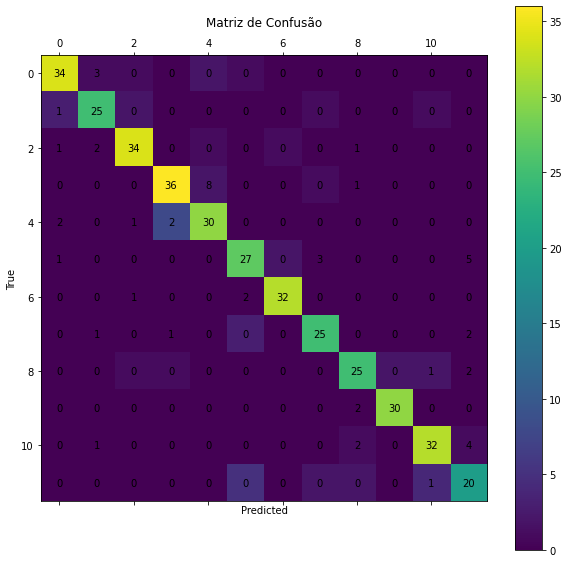

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

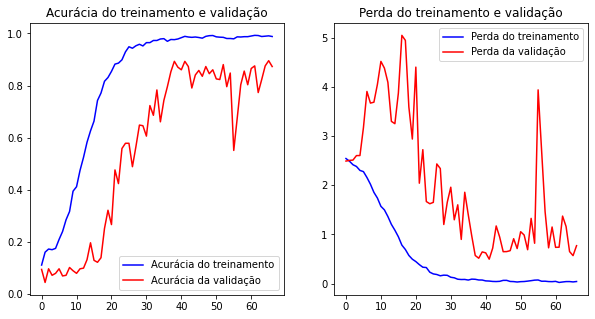

DONE


In [ ]:
## Definitions
NUM_CLASSES = 12
IMG_ROWS = 48
IMG_COLS = 48
BATCH_SIZE = 128
epochs = 160

## Loading Initial Data
(x_train, y_train), (x_test, y_test) = load_dataset(TRAIN_FILE, TEST_FILE, resize=True, convert=True, size=(IMG_ROWS, IMG_COLS))

# Normalize images
x_train = normalize_images(x_train)
x_test = normalize_images(x_test)

## Generating Labels for Confusion Matrix
labels = generate_labels(x_test, y_test)

## Convert class vectros to binary class matrices
y_train = convert_vector(y_train, NUM_CLASSES)
y_test = convert_vector(y_test, NUM_CLASSES)

model = cnn_model(IMG_ROWS, IMG_COLS, NUM_CLASSES)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
callbacks = [EarlyStopping(monitor='val_loss', patience=25),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
## Star Time
checkpoint_time = get_time()
history = model.fit(x=x_train, y=y_train, 
                    epochs=epochs, batch_size=BATCH_SIZE, validation_data=(x_test, y_test), 
                    callbacks=callbacks, shuffle=True, verbose=0)

## Getting Score
score = model.evaluate(x_test, y_test, verbose=0)

## Loss
print('Loss:', score[0])

## Accuracy
print('Accuracy:', score[1])

## Execution Time
print(f'Execution Time: {get_time_diff(checkpoint_time)}')

## Confusion Matrix
cm = get_confusion_matrix(model, x_test, labels)
print(f'Confusion Matrix: \n', cm)
plot_confusion_matrix(cm, 'cm_simple_cnn.pdf')
# plot_confusion_matrix(cm)

## Graphs
plot_graphs(history, 'history_simple_cnn.pdf')
# plot_graphs(history)

print('DONE')


## Preparação para testes com dados augumentados


In [ ]:
import shutil

TRAIN_AUG_FILE = './ml_lab3/train-aug.txt'
TRAIN_FINAL = './ml_lab3/train-final.txt'

def mergeTrainFiles():
  filenames = [TRAIN_FILE, TRAIN_AUG_FILE]
  with open(TRAIN_FINAL, 'w') as outfile:
      for fname in filenames:
          with open(fname) as infile:
              for line in infile:
                  outfile.write(line)

mergeTrainFiles()

print('Preparando o arquivo de treino - DONE')

Preparando o arquivo de treino - DONE


Size: (48, 48)
Loading training set...
Loading testing set...
Resizing images...
(37358, 48, 48, 3)
Epoch 1/160
584/584 [==============================] - 11s 18ms/step - loss: 2.2772 - accuracy: 0.1894 - val_loss: 3.8541 - val_accuracy: 0.1272
Epoch 2/160
584/584 [==============================] - 10s 17ms/step - loss: 1.3004 - accuracy: 0.5678 - val_loss: 5.7185 - val_accuracy: 0.2818
Epoch 3/160
584/584 [==============================] - 10s 18ms/step - loss: 0.7954 - accuracy: 0.7466 - val_loss: 1.2034 - val_accuracy: 0.6559
Epoch 4/160
584/584 [==============================] - 10s 18ms/step - loss: 0.6192 - accuracy: 0.8059 - val_loss: 0.7568 - val_accuracy: 0.7456
Epoch 5/160
584/584 [==============================] - 10s 18ms/step - loss: 0.5193 - accuracy: 0.8380 - val_loss: 0.4747 - val_accuracy: 0.8504
Epoch 6/160
584/584 [==============================] - 10s 18ms/step - loss: 0.4461 - accuracy: 0.8616 - val_loss: 0.5118 - val_accuracy: 0.8554
Epoch 7/160
584/584 [=========

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

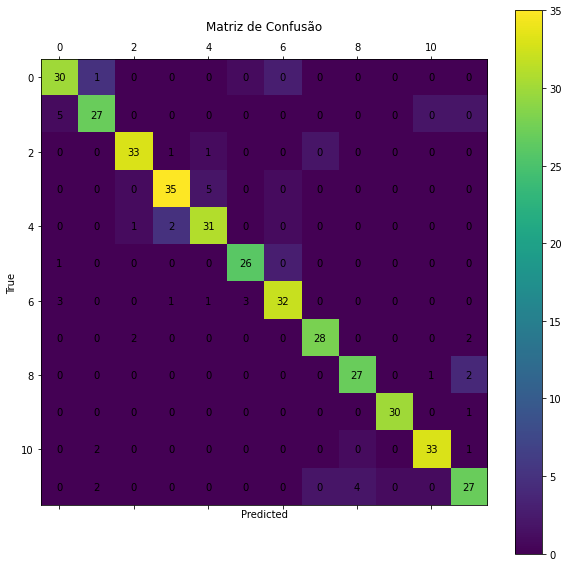

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

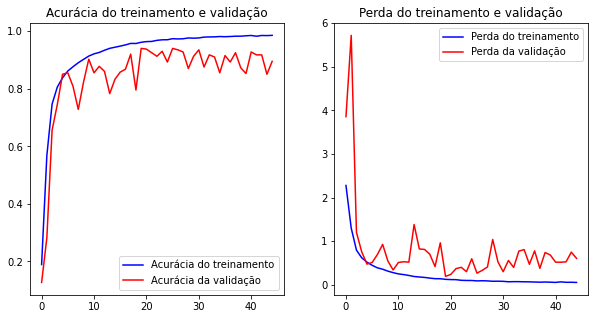

DONE


In [ ]:
## Definitions
NUM_CLASSES = 12
IMG_ROWS = 48
IMG_COLS = 48
BATCH_SIZE = 64
epochs = 160

## Loading Initial Data
(x_train, y_train), (x_test, y_test) = load_dataset(TRAIN_FINAL, TEST_FILE, resize=True, convert=True, size=(IMG_ROWS, IMG_COLS))

# Normalize images
x_train = normalize_images(x_train)
x_test = normalize_images(x_test)

## Generating Labels for Confusion Matrix
labels = generate_labels(x_test, y_test)

## Convert class vectros to binary class matrices
y_train = convert_vector(y_train, NUM_CLASSES)
y_test = convert_vector(y_test, NUM_CLASSES)

model = cnn_model(IMG_ROWS, IMG_COLS, NUM_CLASSES)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
callbacks = [EarlyStopping(monitor='val_loss', patience=25),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
## Star Time
checkpoint_time = get_time()
history = model.fit(x=x_train, y=y_train, 
                    epochs=epochs, batch_size=BATCH_SIZE, validation_data=(x_test, y_test), 
                    callbacks=callbacks, shuffle=True, verbose=1)

## Getting Score
score = model.evaluate(x_test, y_test, verbose=0)

## Loss
print('Loss:', score[0])

## Accuracy
print('Accuracy:', score[1])

## Execution Time
print(f'Execution Time: {get_time_diff(checkpoint_time)}')

## Confusion Matrix
cm = get_confusion_matrix(model, x_test, labels)
print(f'Confusion Matrix: \n', cm)
plot_confusion_matrix(cm, 'cm_simple_cnn.pdf')
# plot_confusion_matrix(cm)

## Graphs
plot_graphs(history, 'history_simple_cnn.pdf')
# plot_graphs(history)

print('DONE')


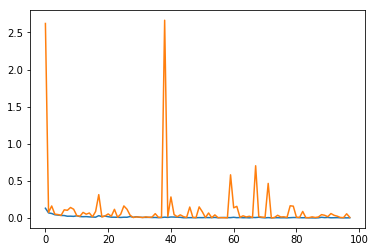

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

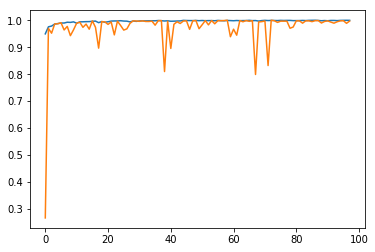

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

# Load the test data and evaluate the model

Load the best performing model based on the validation loss.

In [ ]:
model.load_weights("best_model.h5")

In [ ]:
test_folder = "../input/test/"
test_datagen = ImageDataGenerator(
    rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=test_folder,
    target_size=(32,32),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

Found 4000 images belonging to 1 classes.


In [ ]:
pred=model.predict_generator(test_generator,verbose=1)
pred_binary = [0 if value<0.50 else 1 for value in pred]  

4000/4000 [==============================] - 38s 9ms/step


Generate the submission .csv file.

In [ ]:
csv_file = open("sample_submission_cnn.csv","w")
csv_file.write("id,has_cactus\n")
for filename, prediction in zip(test_generator.filenames,pred_binary):
    name = filename.split("/")[1].replace(".tif","")
    csv_file.write(str(name)+","+str(prediction)+"\n")
csv_file.close()